In [2]:
import orbipy as op
import numpy as np
import matplotlib.pyplot as plt
from orbipy import model_event
from scipy import interpolate
import math

### Generate PR dataset (polar radius data from libration point to the HLO)

In [3]:
def get_polar_coordinates(state, center):
    """
    Returns polar coordinates of a state relative to the libration point (center is an x coordinate of a libration point in this case)
    """
    x, y, z = state[0] - center, state[1], state[2]
    r = x ** 2 + y ** 2 + z ** 2
    
    theta = math.atan2((y ** 2 + z ** 2) ** 0.5, -x) # for 3 dimensions this does not keep the sign of y btw.
    # Also we flip the x coordinate ("-x"), because eventSPL by default thinks data is for L2 point, and it flips the x coordinate if the point is L1 (which it is - unless specified, as well. weird, yes)
    
    return theta, r

def generate_pr_data_for_orbit(data):
    """
    Generates a list of polar radii, interpolated from 720 polar angles points, from 0 to 180 degrees.
    :param data: xy data of half the horizontal lyapunov orbit (from 0 to 180 in polar degrees)
    """
    polar_coordinates = np.array([get_polar_coordinates(state, model.L1) for state in data])
    thetas = polar_coordinates[:,0]
    rs = polar_coordinates[:,1]
    
    interpolation = interpolate.interp1d(thetas, rs, kind='cubic', fill_value='extrapolate')
    thetas_720 = np.linspace(0, np.pi, 720) # 720 angle points is the hardcoded number in eventSPL
    rs_new = interpolation(thetas_720)
    return rs_new

In [4]:
# Pick system
# available systems (constant sets for systems)
systems = list(op.crtbp3_model.constants_df.index)
systems

['Sun-Earth (default)',
 'Earth-Moon (default)',
 'Sun-Venus (2026-12-05)',
 'Extreme 0.49']

In [5]:
# USER: select system
system = systems[1]
model = op.crtbp3_model(system)  #model for calculations

In [6]:
hl_orbits = np.loadtxt('../data/datasets/HLY_L1_Earth-Moon (default).csv') # dataset of horizontal lyapunov orbits

# for each initial state in the dataset of hly orbits, generate the list of polar radii from half of their orbit
pr_dataset = []
for _, orbit in enumerate(hl_orbits):
    print(_, end=' ')
    zero_state = model.get_zero_state().copy()
    zero_state[0] = orbit[0]
    zero_state[2] = orbit[2]
    zero_state[4] = orbit[4]

    # calculating points that represent half of a period of a current hly orbit
    event = [op.eventY(count=3)]
    det = op.event_detector(model, event)
    df, ev = det.prop(zero_state, 0.0, np.pi*3, last_state='last')
    
    df_half = df[(df['t'] >= ev.iloc[0]['t']) & (df['t'] <= ev.iloc[1]['t'])] # calculating timestamps of first 2 trajectory crossings of the x axis
    df_numpy = df_half[['x','y','z']].to_numpy() # numpy array of xyz coordinates for half-period of current hly orbit

    pr = generate_pr_data_for_orbit(df_numpy)
    pr_dataset.append(pr)
    
pr_dataset_numpy = np.array(pr_dataset)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [7]:
np.save('../data/datasets/PR_HLY_L1_Earth-Moon (default).npy', pr_dataset_numpy)
print(pr_dataset_numpy[0])

[ 4.60749436e-06  4.55962217e-06  4.51207652e-06  4.46485635e-06
  4.41796055e-06  4.37138806e-06  4.32513779e-06  4.27920865e-06
  4.23359957e-06  4.18830946e-06  4.14333724e-06  4.09868182e-06
  4.05434213e-06  4.01031708e-06  3.96660559e-06  3.92320658e-06
  3.88011896e-06  3.83734165e-06  3.79487357e-06  3.75271363e-06
  3.71086076e-06  3.66931387e-06  3.62807188e-06  3.58713370e-06
  3.54649826e-06  3.50616447e-06  3.46613125e-06  3.42639751e-06
  3.38696217e-06  3.34782416e-06  3.30898238e-06  3.27043576e-06
  3.23218322e-06  3.19422366e-06  3.15655601e-06  3.11917919e-06
  3.08209211e-06  3.04529369e-06  3.00878285e-06  2.97255850e-06
  2.93661956e-06  2.90096496e-06  2.86559360e-06  2.83050441e-06
  2.79569630e-06  2.76116819e-06  2.72691900e-06  2.69294765e-06
  2.65925304e-06  2.62583411e-06  2.59268976e-06  2.55981892e-06
  2.52722050e-06  2.49489342e-06  2.46283660e-06  2.43104895e-06
  2.39952939e-06  2.36827684e-06  2.33729022e-06  2.30656845e-06
  2.27611043e-06  2.24591

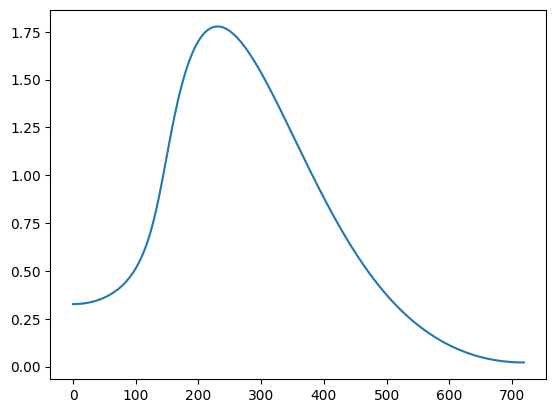

In [8]:
plt.plot(pr_dataset_numpy[-1])

### Generate SP dataset (jacobi constant of hlo, jacobi constant of the target orbit, angle theta of split point)

In [9]:
def get_xy_from_polar_coordinates(theta, r):
    x = (r**0.5) * np.cos(theta)
    x = -x # Flip back from the already flipped position, because its an L1 point
    x += model.L1
    y = (r**0.5) * np.sin(theta) # Why r**0.5??? But it works
    return np.column_stack((x, y))

def calculate_velocity_from_jacobi_constant(xy, J):
    """
    Knowing xyz state and the jacobi constant, solve the first integral equation for |v|
    """
    return 2*model.omega(np.array([xy[0], xy[1], 0.0])) - J

def mask(velocity):
    return np.where(velocity <= 0)[0].size

def find_jc_threshold_multiplier(J_HLY, xy_coordinates, criteria=1, lower=1.0, upper=2.0, tol=1e-20, max_iter=100):
    """
    Given jacobi constant of a hl orbit and its xy coordinates, calculates the perfect jacobi constant of a lower energy, in order to find the forbidden zone for this hlo and find the correct dividing angle theta.

    When one plugs into the calculate_velocity_from_jacobi_constant function jacobi constant that does NOT match the plugged xyz state (in this example the jacobi constant is a bit larger => a bit lower energy), the function may return negative velocity. Negative velocity means a forbidden region, because remember that the mentioned functioned returns |v|.

    This function using binary search finds the smallest deviation (from the given jacobi constant of a hly orbit) that gives a forbidden region (a region with negative velocity), and returns the resulted constant.
    """
    for _ in range(max_iter):
        jc_multiplier = (lower + upper) / 2.0
        J0 = J_HLY * jc_multiplier
        velocity_array = np.array([calculate_velocity_from_jacobi_constant(xyi, J0) for xyi in xy_coordinates])

        count = mask(velocity_array)
        
        if count > 0:
            # Current multiplier is "sufficient", try to lower it further.
            upper = jc_multiplier
        else:
            # Not enough elements, need to increase the multiplier.
            lower = jc_multiplier
        
        if (upper - lower) < tol:
            print("tol")
            break
        if criteria >= count > 0: # change the "criteria" number to change the minimum required amount of negative velocity coordinates
            print("low enough")
            break
    return jc_multiplier, velocity_array

In [10]:
rs = pr_dataset_numpy

J_HLYs = np.array([model.jacobi(state) for state in hl_orbits])

sp_dataset = []

# for each orbit in the dataset, find the forbidden region, corresponding jacobi constant and the angle theta
for i in range(len(hl_orbits)):
    thetas = np.linspace(0., np.pi, 720) # 720 - magic number from eventSPL
    xy_coordinates = get_xy_from_polar_coordinates(thetas, rs[i])
    J_HLY = J_HLYs[i]
    
    multiplier, velocity = find_jc_threshold_multiplier(J_HLY, xy_coordinates)
    
    split_point = thetas[int(np.where(velocity <= 0)[0].mean())] # finds the middle point of the forbidden region and the corresponding theta angle
    print(f'{i}: {split_point}, {len(np.where(velocity <= 0)[0])}')
    sp_dataset.append(np.array([J_HLY, J_HLY*multiplier, split_point]))
    
sp_dataset_numpy = np.array(sp_dataset)

/tmp/ipykernel_2210984/322781441.py:2: RuntimeWarning: invalid value encountered in sqrt
  x = (r**0.5) * np.cos(theta)
/tmp/ipykernel_2210984/322781441.py:5: RuntimeWarning: invalid value encountered in sqrt
  y = (r**0.5) * np.sin(theta) # Why r**0.5??? But it works


low enough
0: 1.564242239200481, 1
low enough
1: 1.5686116309300913, 1
low enough
2: 1.5773504143893118, 1
low enough
3: 1.5686116309300913, 1
low enough
4: 1.5729810226597016, 1
low enough
5: 1.5773504143893118, 1
low enough
6: 1.5773504143893118, 1
low enough
7: 1.5773504143893118, 1
low enough
8: 1.5729810226597016, 1
low enough
9: 1.5729810226597016, 1
low enough
10: 1.5729810226597016, 1
low enough
11: 1.5729810226597016, 1
low enough
12: 1.5773504143893118, 1
low enough
13: 1.5773504143893118, 1
low enough
14: 1.5773504143893118, 1
low enough
15: 1.5773504143893118, 1
low enough
16: 1.5773504143893118, 1
low enough
17: 1.5817198061189222, 1
low enough
18: 1.5817198061189222, 1
low enough
19: 1.5817198061189222, 1
low enough
20: 1.5817198061189222, 1
low enough
21: 1.5817198061189222, 1
low enough
22: 1.5817198061189222, 1
low enough
23: 1.5817198061189222, 1
low enough
24: 1.5817198061189222, 1
low enough
25: 1.5817198061189222, 1
low enough
26: 1.5817198061189222, 1
low enough
2

In [11]:
np.savetxt("../data/datasets/SP_HLY_L1_Earth-Moon (default).csv", sp_dataset_numpy)

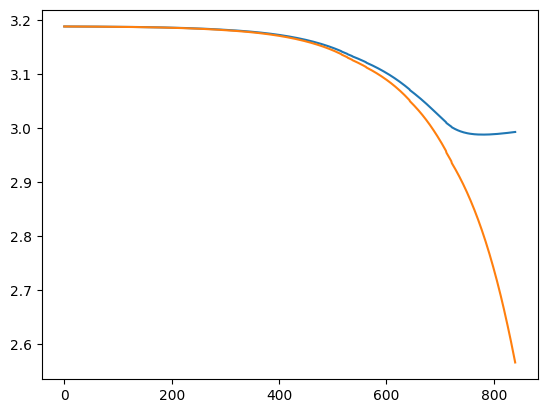

In [12]:
generated = np.loadtxt('../data/datasets/SP_HLY_L1_Earth-Moon (default).csv')
plt.plot(generated[:,1])
plt.plot(generated[:,0])

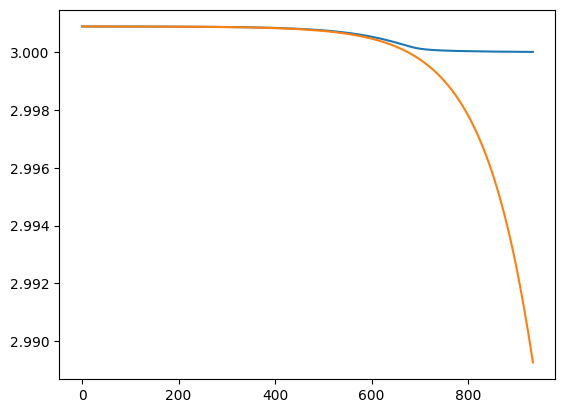

In [13]:
existing = np.loadtxt('../data/datasets/SP_HLY_L1_Sun-Earth (default).csv')
plt.plot(existing[:,1])
plt.plot(existing[:,0])

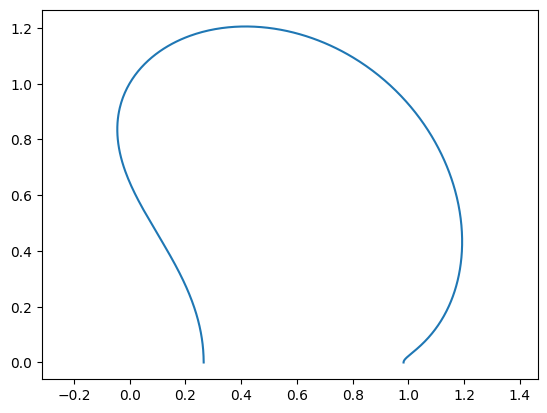

In [15]:
plt.axis('equal')
plt.plot(xy_coordinates[:, 0], xy_coordinates[:, 1])


/tmp/ipykernel_2210984/322781441.py:2: RuntimeWarning: invalid value encountered in sqrt
  x = (r**0.5) * np.cos(theta)
/tmp/ipykernel_2210984/322781441.py:5: RuntimeWarning: invalid value encountered in sqrt
  y = (r**0.5) * np.sin(theta) # Why r**0.5??? But it works


low enough
500: 1.7696036504921642, 1
low enough
510: 1.778342433951385, 1
low enough
520: 1.7914506091402156, 1
low enough
530: 1.8001893925994363, 1
low enough
540: 1.8089281760586569, 1
low enough
550: 1.8176669595178774, 1
low enough
560: 1.826405742977098, 1
low enough
570: 1.8351445264363184, 1
low enough
580: 1.8438833098955392, 1
low enough
590: 1.8526220933547597, 1
low enough
600: 1.8613608768139802, 1
low enough
610: 1.8700996602732007, 1
low enough
620: 1.8788384437324213, 1
low enough
630: 1.8875772271916418, 1
low enough
640: 1.8919466189212522, 1
low enough
650: 1.8963160106508625, 1
low enough
660: 1.8963160106508625, 1
low enough
670: 1.8875772271916418, 1
low enough
680: 1.8700996602732007, 1
low enough
690: 1.8395139181659288, 1
low enough
700: 1.7870812174106054, 1
low enough
710: 1.7171709497368408, 1
low enough
720: 1.625413723415025, 1
low enough
730: 1.5380258888228193, 1
low enough
740: 1.4593768376898342, 1
low enough
750: 1.3807277865568492, 1
low enough
760:

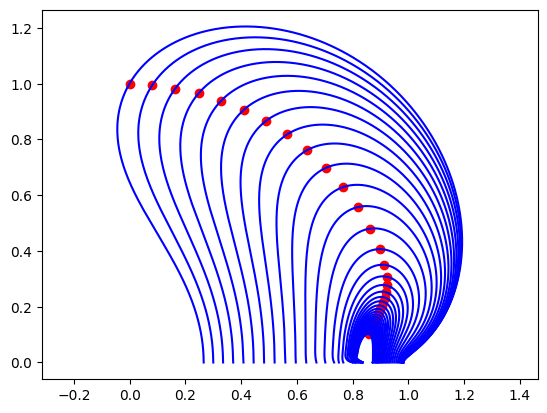

In [38]:
rs = pr_dataset_numpy

J_HLYs = np.array([model.jacobi(state) for state in hl_orbits])

sp_dataset = []

# for each orbit in the dataset, find the forbidden region, corresponding jacobi constant and the angle theta
# fig, ax = plt.figure(figsize=(5,5))
plt.axis('equal')

for i in range(500,len(hl_orbits),10):
    thetas = np.linspace(0., np.pi, 720) # 720 - magic number from eventSPL
    xy_coordinates = get_xy_from_polar_coordinates(thetas, rs[i])
    J_HLY = J_HLYs[i]

    plt.plot(xy_coordinates[:, 0], xy_coordinates[:, 1], 'b')
    multiplier, velocity = find_jc_threshold_multiplier(J_HLY, xy_coordinates)

    split_point = thetas[int(np.where(velocity <= 0)[0].mean())] # finds the middle point of the forbidden region and the corresponding theta angle
    plt.scatter(*get_xy_from_polar_coordinates(split_point, rs[i][int(np.where(velocity <= 0)[0].mean())])[0], c='r')
    print(f'{i}: {split_point}, {len(np.where(velocity <= 0)[0])}')
    sp_dataset.append(np.array([J_HLY, J_HLY*multiplier, split_point]))

sp_dataset_numpy = np.array(sp_dataset)